# Import Libraries

In [1]:
##data analysis libraries
import numpy as np
import pandas as pd

##visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("darkgrid")

from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from scipy import stats
import missingno as msno

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import jarque_bera
from scipy.stats import normaltest


pd.set_option('display.max_columns', None)

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Getting Data

In [2]:
df = pd.read_csv('train.csv')
df.head(5)

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,preferred_offer_types,medium_of_operation,internet_option,last_visit_time,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,Gift Vouchers/Coupons,?,Wi-Fi,16:08:02,17,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,Gift Vouchers/Coupons,Desktop,Mobile_Data,12:38:13,16,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,Gift Vouchers/Coupons,Desktop,Wi-Fi,22:53:21,14,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,Gift Vouchers/Coupons,Desktop,Mobile_Data,15:57:50,11,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,Credit/Debit Card Offers,Smartphone,Mobile_Data,15:46:44,20,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


In [3]:
df.shape

(36992, 25)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

In [5]:
df['joining_date']=pd.to_datetime(df['joining_date'])
df['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'], errors='coerce')

In [6]:
df.nunique()

customer_id                     36992
Name                            36992
age                                55
gender                              3
security_no                     36992
region_category                     3
membership_category                 6
joining_date                     1096
joined_through_referral             3
referral_id                     11359
preferred_offer_types               3
medium_of_operation                 4
internet_option                     3
last_visit_time                 30101
days_since_last_login              27
avg_time_spent                  25961
avg_transaction_value           36894
avg_frequency_login_days         1653
points_in_wallet                23699
used_special_discount               2
offer_application_preference        2
past_complaint                      2
complaint_status                    5
feedback                            9
churn_risk_score                    6
dtype: int64

In [7]:
drops = ['customer_id', 'Name', 'security_no', 'referral_id', 'last_visit_time']
df.drop(drops, axis=1, inplace=True)

# EDA

In [8]:
df.describe(percentiles=[.01, .1, .25, .5, .75, .9, .95, .99])

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,33470.000000,33549.000000,36992.000000
mean,37.118161,-41.915576,243.472334,29271.194003,15.976715,686.882199,3.463397
std,15.867412,228.819900,398.289149,19444.806226,9.215858,194.063624,1.409661
min,10.000000,-999.000000,-2814.109110,800.460000,-43.652702,-760.661236,-1.000000
1%,10.000000,-999.000000,-948.781579,1325.127900,-10.524594,113.627063,-1.000000
10%,15.000000,3.000000,32.290000,6198.329000,6.000000,512.168000,1.000000
25%,23.000000,8.000000,60.102500,14177.540000,9.000000,616.150000,3.000000
50%,37.000000,12.000000,161.765000,27554.485000,16.000000,697.620000,4.000000
75%,51.000000,16.000000,356.515000,40855.110000,23.000000,763.950000,5.000000
90%,59.000000,20.000000,702.668000,48789.279000,27.000000,829.004000,5.000000


In [9]:
df[df['days_since_last_login'] < 0].describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,1999.000000,1999.0,1999.000000,1999.000000,1817.000000,1832.000000,1999.000000
mean,37.378689,-999.0,243.945305,28919.117614,15.965790,679.628380,3.524762
std,16.000287,0.0,383.407799,19500.144677,9.140445,196.728108,1.344273
min,10.000000,-999.0,-2034.801880,840.340000,-37.424778,-301.998780,-1.000000
25%,23.000000,-999.0,60.570000,13749.385000,10.000000,612.060000,3.000000
50%,38.000000,-999.0,166.170000,27170.460000,16.000000,689.020000,4.000000
75%,51.000000,-999.0,347.800000,40378.940000,23.000000,759.475000,5.000000
max,64.000000,-999.0,2341.451934,99696.230000,73.061995,1755.094693,5.000000


In [10]:
df[df['avg_time_spent'] < 0].describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,1719.000000,1719.000000,1719.000000,1719.000000,1539.000000,1568.000000,1719.000000
mean,36.898197,-36.823735,-767.710232,29076.914444,15.884530,684.302135,3.474113
std,15.892779,218.223342,283.577884,19101.741521,9.558929,203.000076,1.438818
min,10.000000,-999.000000,-2814.109110,829.410000,-23.920713,-315.897438,-1.000000
25%,23.000000,8.000000,-924.388276,13857.330000,9.000000,616.630000,3.000000
50%,37.000000,12.000000,-778.915502,27707.280000,16.000000,690.870000,4.000000
75%,51.000000,16.000000,-631.340527,41248.575000,23.000000,765.657500,5.000000
max,64.000000,26.000000,-12.338460,99353.370000,53.632678,1637.676500,5.000000


In [11]:
df[df['churn_risk_score'] == -1].describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,1163.000000,1163.000000,1163.000000,1163.000000,1060.000000,1061.000000,1163.0
mean,37.053310,-34.881341,246.506069,28252.137678,16.394834,687.891670,-1.0
std,15.937234,214.963315,413.696001,18155.697939,9.509753,177.792796,0.0
min,10.000000,-999.000000,-1621.281883,941.740000,-25.528875,-56.222644,-1.0
25%,23.000000,8.000000,66.340000,13771.290000,9.000000,619.890000,-1.0
50%,37.000000,13.000000,167.690000,26853.870000,16.602557,693.370000,-1.0
75%,51.000000,17.000000,361.330000,40452.505000,23.000000,761.560000,-1.0
max,64.000000,26.000000,2766.750000,99455.790000,54.709092,1551.854854,-1.0


In [12]:
df[df['avg_frequency_login_days'] < 0 ].describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,683.000000,683.000000,683.000000,683.000000,683.000000,615.000000,683.000000
mean,37.282577,-43.904832,216.247642,30494.824890,-10.996924,689.945566,3.407028
std,16.257570,232.058393,419.833697,18916.218941,6.732338,201.570199,1.469557
min,10.000000,-999.000000,-1837.008370,868.940000,-43.652702,-276.580911,-1.000000
25%,23.000000,7.000000,62.155000,15200.440000,-15.861912,614.230000,3.000000
50%,36.000000,12.000000,168.430000,30156.970000,-10.457816,700.920000,4.000000
75%,52.000000,16.000000,341.195000,42214.405000,-5.814585,762.795000,5.000000
max,64.000000,26.000000,1682.530000,99316.470000,-0.006221,1763.351594,5.000000


In [13]:
df = df.loc[(df['days_since_last_login'] >= 0) & \
            (df['avg_time_spent'] >= 0) & \
            (df['churn_risk_score'] != -1) & \
            (df['avg_frequency_login_days'] >= 0)]

In [14]:
df.shape

(28656, 20)

In [15]:
df.describe(percentiles=[.01, .1, .25, .5, .75, .9, .95,.99])

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,churn_risk_score
count,28656.00000,28656.000000,28656.000000,28656.000000,28656.000000,25968.000000,28656.000000
mean,37.07946,12.767658,292.224349,29251.060544,16.509122,687.771693,3.604585
std,15.86664,5.567645,331.845372,19467.297298,8.378800,194.349455,1.178984
min,10.00000,1.000000,1.837399,800.460000,0.009208,-760.661236,1.000000
1%,10.00000,2.000000,30.440000,1342.937500,2.000000,111.534871,1.000000
10%,15.00000,5.000000,33.930000,6255.745000,6.000000,512.854647,2.000000
25%,23.00000,9.000000,71.000000,14217.310000,10.000000,616.425000,3.000000
50%,37.00000,13.000000,173.520000,27435.845000,16.000000,698.880000,4.000000
75%,51.00000,17.000000,370.425000,40759.400000,23.000000,764.472500,5.000000
90%,59.00000,20.000000,727.135000,48764.325000,27.000000,832.018000,5.000000


In [16]:
df['churn_risk_score'] = df['churn_risk_score'].astype(str)

In [17]:
#checking for null values
(df.isnull().sum() * 100 / len(df)).sort_values(ascending=False)

region_category                 14.688023
points_in_wallet                 9.380235
preferred_offer_types            0.774707
age                              0.000000
avg_transaction_value            0.000000
feedback                         0.000000
complaint_status                 0.000000
past_complaint                   0.000000
offer_application_preference     0.000000
used_special_discount            0.000000
avg_frequency_login_days         0.000000
avg_time_spent                   0.000000
gender                           0.000000
days_since_last_login            0.000000
internet_option                  0.000000
medium_of_operation              0.000000
joined_through_referral          0.000000
joining_date                     0.000000
membership_category              0.000000
churn_risk_score                 0.000000
dtype: float64

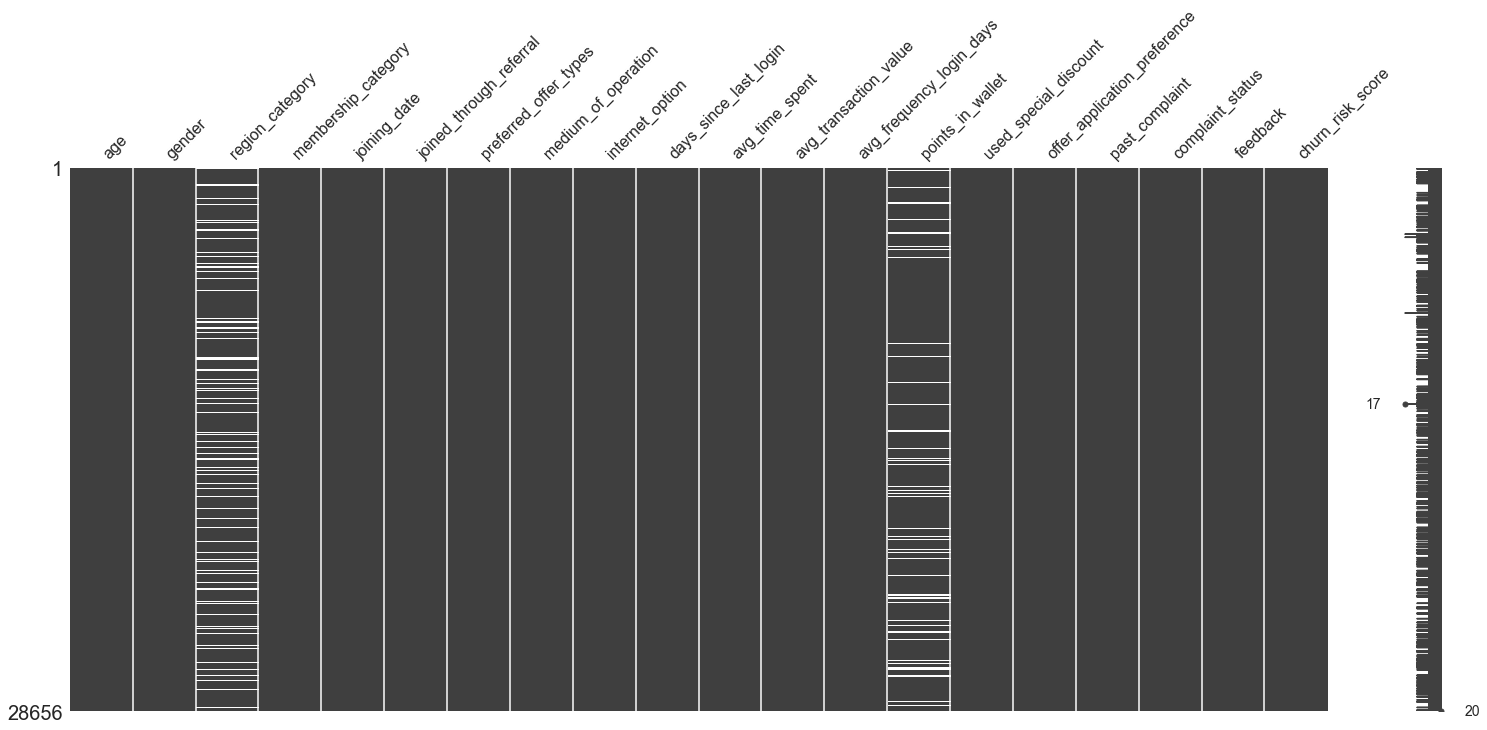

In [18]:
msno.matrix(df) # Visualize missing values as a matrix. The white lines indicate the missing values in each column. 
plt.show()

In [19]:
nums = [col for col in df.columns if (df[col].dtypes == "int64") | (df[col].dtypes == "float64")]
for col in nums :
    print("Incorrect values for {} column : ".format(col))
    incorrect_values = []
    for value in df[col]:
        try:
            float(value)
        except:
            incorrect_values.append(value)
    print(set(incorrect_values))

Incorrect values for age column : 
set()
Incorrect values for days_since_last_login column : 
set()
Incorrect values for avg_time_spent column : 
set()
Incorrect values for avg_transaction_value column : 
set()
Incorrect values for avg_frequency_login_days column : 
set()
Incorrect values for points_in_wallet column : 
set()


In [20]:
df.groupby('churn_risk_score')[['points_in_wallet']].median()

,points_in_wallet
churn_risk_score,
1,801.910
2,747.455
3,750.410
4,660.840
5,599.650


In [21]:
df.groupby('churn_risk_score')[['points_in_wallet']].mean()

,points_in_wallet
churn_risk_score,
1,797.096827
2,747.053109
3,750.585608
4,661.636867
5,601.303066


In [22]:
df['points_in_wallet'] = df.groupby('churn_risk_score').points_in_wallet.apply(lambda x: x.fillna(x.mean()))

In [23]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
for i in cat_cols:
    print(i, ':', (df[i].unique()), '\n')
    print('=' * 80, '\n')

gender : ['F' 'M' 'Unknown'] 


region_category : ['Village' 'City' 'Town' nan] 


membership_category : ['Platinum Membership' 'Premium Membership' 'No Membership'
 'Gold Membership' 'Silver Membership' 'Basic Membership'] 


joined_through_referral : ['No' '?' 'Yes'] 


preferred_offer_types : ['Gift Vouchers/Coupons' 'Credit/Debit Card Offers' 'Without Offers' nan] 


medium_of_operation : ['?' 'Desktop' 'Smartphone' 'Both'] 


internet_option : ['Wi-Fi' 'Mobile_Data' 'Fiber_Optic'] 


used_special_discount : ['Yes' 'No'] 


offer_application_preference : ['Yes' 'No'] 


past_complaint : ['No' 'Yes'] 


complaint_status : ['Not Applicable' 'Solved' 'Solved in Follow-up' 'Unsolved'
 'No Information Available'] 


feedback : ['Products always in Stock' 'Quality Customer Care' 'Poor Website'
 'No reason specified' 'Poor Product Quality' 'Poor Customer Service'
 'Too many ads' 'User Friendly Website' 'Reasonable Price'] 


churn_risk_score : ['2' '1' '5' '3' '4'] 




In [24]:
for col in cat_cols:
    print(df[col].value_counts(), '\n', '=' * 100)

F          14376
M          14237
Unknown       43
Name: gender, dtype: int64 
Town       10930
City        9869
Village     3648
Name: region_category, dtype: int64 
Basic Membership       5960
No Membership          5949
Gold Membership        5265
Silver Membership      4675
Premium Membership     3438
Platinum Membership    3369
Name: membership_category, dtype: int64 
No     12276
Yes    12151
?       4229
Name: joined_through_referral, dtype: int64 
Gift Vouchers/Coupons       9579
Credit/Debit Card Offers    9516
Without Offers              9339
Name: preferred_offer_types, dtype: int64 
Smartphone    10772
Desktop       10761
?              4165
Both           2958
Name: medium_of_operation, dtype: int64 
Wi-Fi          9617
Fiber_Optic    9569
Mobile_Data    9470
Name: internet_option, dtype: int64 
Yes    15769
No     12887
Name: used_special_discount, dtype: int64 
Yes    15856
No     12800
Name: offer_application_preference, dtype: int64 
No     14438
Yes    14218
Name: pas

In [25]:
df = df[df['gender'] != 'Unknown']

In [26]:
df.replace(to_replace='?', value='Other', inplace=True) 

In [27]:
df[df['region_category'].isnull()].groupby(['membership_category']).agg({'age':'mean', 'avg_time_spent':'mean', 'avg_transaction_value':'mean'})

,age,avg_time_spent,avg_transaction_value
membership_category,,,
Basic Membership,36.757062,301.007718,25021.766068
Gold Membership,36.851091,286.395644,31636.590526
No Membership,37.236633,273.496104,25457.526689
Platinum Membership,37.064718,281.937511,33633.580835
Premium Membership,37.865125,327.307977,34383.484027
Silver Membership,37.181269,263.748863,28112.011662


In [28]:
df.groupby(['region_category', 'membership_category']).agg({'avg_time_spent':'mean', 'avg_transaction_value':'mean'})

avg_time_spent  avg_transaction_value
region_category membership_category                                       
City            Basic Membership         279.670702           25256.946429
                Gold Membership          301.747439           31241.079833
                No Membership            289.394433           25025.173838
                Platinum Membership      305.565769           34672.627633
                Premium Membership       310.698252           34069.032951
                Silver Membership        282.208630           28507.594723
Town            Basic Membership         289.910884           25002.897561
                Gold Membership          286.826477           30593.686603
                No Membership            293.606793           25664.622440
                Platinum Membership      299.752046           35346.597785
                Premium Membership       303.553691           35272.269969
                Silver Membership        289.367432           28380.574420
Village         Basic Membership         283.557577           25272.725694
                Gold Membership          297.294970           32881.985191
                No Membership            306.907096           25482.828212
                Platinum Membership      264.029694           36967.637674
                Premium Membership       297.428828           38223.232128
                Silver Membership        313.641053           30134.176506

In [29]:
df['region_category'] = df['region_category'].fillna('Town')

In [30]:
df.dropna(inplace=True)

In [31]:
df.isnull().sum()

age                             0
gender                          0
region_category                 0
membership_category             0
joining_date                    0
joined_through_referral         0
preferred_offer_types           0
medium_of_operation             0
internet_option                 0
days_since_last_login           0
avg_time_spent                  0
avg_transaction_value           0
avg_frequency_login_days        0
points_in_wallet                0
used_special_discount           0
offer_application_preference    0
past_complaint                  0
complaint_status                0
feedback                        0
churn_risk_score                0
dtype: int64

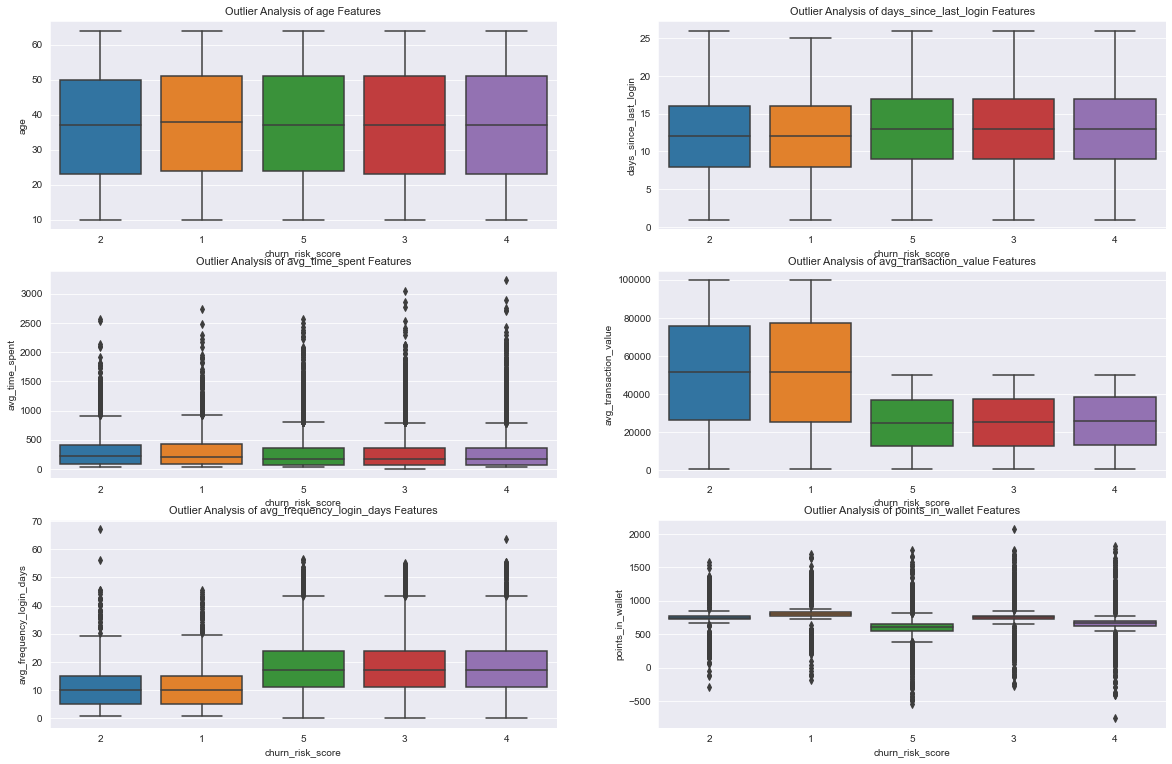

In [32]:
i=1
plt.figure(figsize=(20, 13))
for col in nums:
    plt.subplot(3, 2, i)
    ax = sns.boxplot(x='churn_risk_score', y=col, data=df)
    plt.title('Outlier Analysis of {} Features'.format(col), fontsize=11)
    i+=1
plt.show()

In [33]:
for col in nums : 
    df[col] = stats.mstats.winsorize(df[col], limits=0.01)

In [34]:
df.describe(percentiles=[.01, .1, .25, .5, .75, .9, .95,.99])

,age,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet
count,28392.000000,28392.000000,28392.000000,28392.000000,28392.000000,28392.000000
mean,37.079811,12.774584,289.044460,29224.221000,16.456760,687.829447
std,15.866792,5.529054,316.933245,19346.424449,8.146298,176.098076
min,10.000000,2.000000,30.430000,1342.340000,2.000000,123.823909
1%,10.000000,2.000000,30.430000,1342.485600,2.000000,123.833481
10%,15.000000,5.000000,33.930000,6254.132000,6.000000,521.113661
25%,23.000000,9.000000,71.007500,14223.972500,10.000000,615.127500
50%,37.000000,13.000000,173.520000,27444.005000,16.000000,696.840000
75%,51.000000,17.000000,370.397500,40768.405000,23.000000,759.739996
90%,59.000000,20.000000,727.303000,48773.455000,27.000000,815.435000


In [35]:
for col in cat_cols:   
    print(pd.crosstab(df[col], df['churn_risk_score']))
    print('=' * 50)

churn_risk_score     1     2     3     4     5
gender                                        
F                 1064  1080  4128  4079  3922
M                 1075  1077  4156  3948  3863
churn_risk_score     1     2     3     4     5
region_category                               
City               698   679  2877  2795  2731
Town              1083  1111  4430  4264  4111
Village            358   367   977   968   943
churn_risk_score       1    2     3     4     5
membership_category                            
Basic Membership       0    0     0  2048  3859
Gold Membership      667  508  2039  1997     0
No Membership          0    0     0  1968  3926
Platinum Membership  736  519  2088     0     0
Premium Membership   736  558  2114     0     0
Silver Membership      0  572  2043  2014     0
churn_risk_score            1     2     3     4     5
joined_through_referral                              
No                       1096  1066  3468  3294  3254
Other                     304  

In [36]:
for col in cat_cols:   
    print(pd.crosstab(df[col], df['churn_risk_score']))
    print('=' * 50)

churn_risk_score     1     2     3     4     5
gender                                        
F                 1064  1080  4128  4079  3922
M                 1075  1077  4156  3948  3863
churn_risk_score     1     2     3     4     5
region_category                               
City               698   679  2877  2795  2731
Town              1083  1111  4430  4264  4111
Village            358   367   977   968   943
churn_risk_score       1    2     3     4     5
membership_category                            
Basic Membership       0    0     0  2048  3859
Gold Membership      667  508  2039  1997     0
No Membership          0    0     0  1968  3926
Platinum Membership  736  519  2088     0     0
Premium Membership   736  558  2114     0     0
Silver Membership      0  572  2043  2014     0
churn_risk_score            1     2     3     4     5
joined_through_referral                              
No                       1096  1066  3468  3294  3254
Other                     304  

                        age
churn_risk_score           
1                 37.464703
2                 36.781641
3                 36.885080
4                 37.226361
5                 37.112781


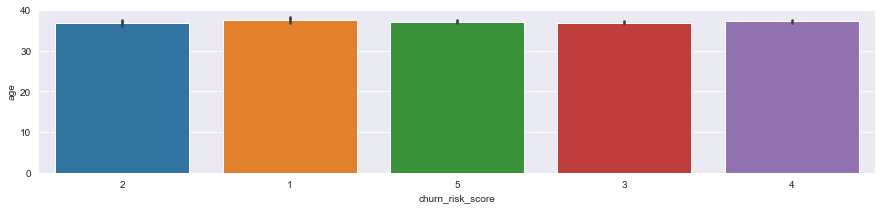

                  days_since_last_login
churn_risk_score                       
1                             12.197756
2                             12.159944
3                             12.892323
4                             12.923882
5                             12.824149


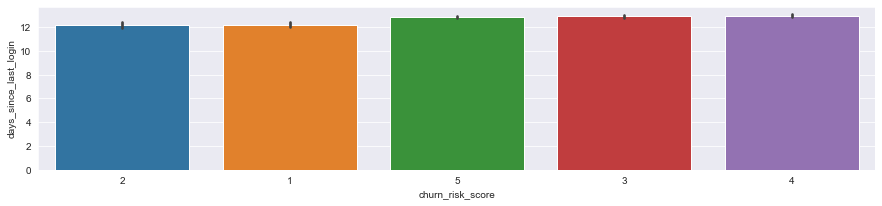

                  avg_time_spent
churn_risk_score                
1                     322.639058
2                     317.410721
3                     279.580691
4                     287.254053
5                     283.870997


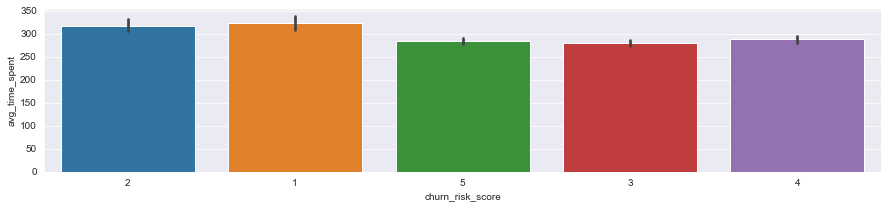

                  avg_transaction_value
churn_risk_score                       
1                          50678.869682
2                          50875.371238
3                          25357.979842
4                          25741.576103
5                          25035.410176


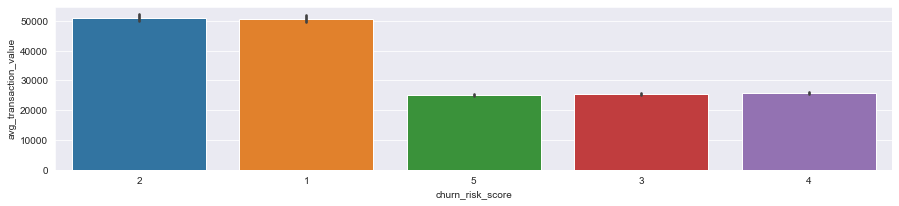

                  avg_frequency_login_days
churn_risk_score                          
1                                10.720427
2                                10.543180
3                                17.328426
4                                17.576388
5                                17.589382


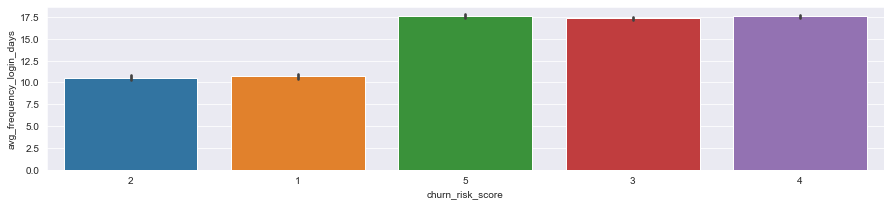

                  points_in_wallet
churn_risk_score                  
1                       794.775152
2                       746.848977
3                       749.533173
4                       661.951852
5                       603.115741


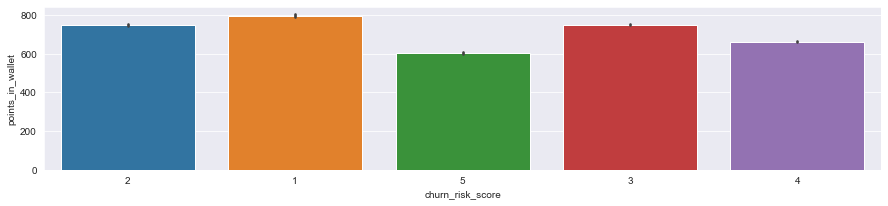

In [37]:
for col in nums:   
    plt.figure(figsize=(15,3))
    print(df.groupby('churn_risk_score').agg({col:'mean'}))
    sns.barplot(x='churn_risk_score', y=col, data=df)
    plt.show()
    print('=' * 100)

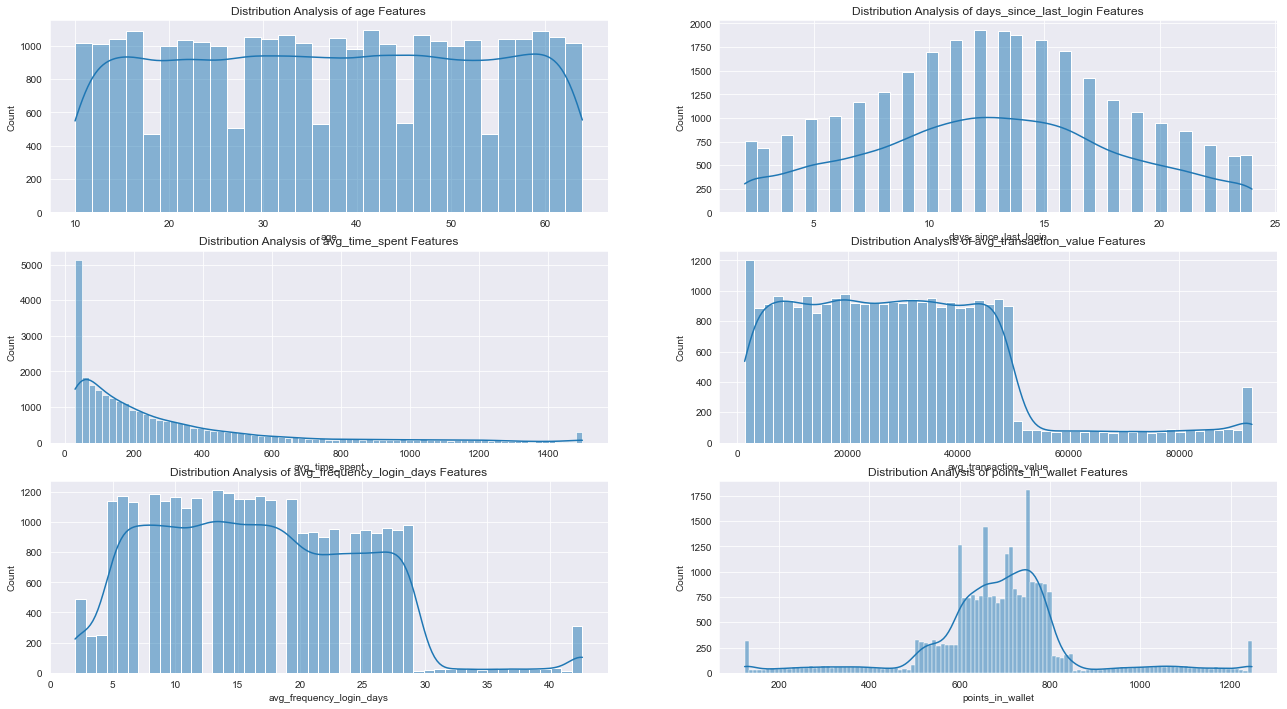

In [38]:
i=1
plt.figure(figsize=(22, 12))
for col in nums:
    plt.subplot(3, 2, i)
    ax = sns.histplot(data=df, x=col, kde=True)
    plt.title('Distribution Analysis of {} Features'.format(col), fontsize=12)
    i+=1
plt.show()

In [39]:
pd.options.display.float_format = '{:.8f}'.format

distribution_tests = pd.DataFrame(columns=['feature', 'jarque_bera_stats', 'jarque_bera_p_value', 
                                         'normal_stats', 'normal_p_value'])

for col in nums:
    jb_stats = jarque_bera(np.log(df[col]))
    norm_stats = normaltest(np.log(df[col]))
    distribution_tests = distribution_tests.append({"feature": col,
                                                    "jarque_bera_stats" : jb_stats[0] ,
                                                    "jarque_bera_p_value" : jb_stats[1] ,
                                                    "normal_stats": norm_stats[0] , 
                                                    "normal_p_value" : norm_stats[1]
                                                    }, ignore_index=True)

In [40]:
distribution_tests

,feature,jarque_bera_stats,jarque_bera_p_value,normal_stats,normal_p_value
0,age,2468.88519119,0.00000000,2609.37089171,0.00000000
1,days_since_last_login,8172.51872112,0.00000000,4941.29317885,0.00000000
2,avg_time_spent,1045.37265075,0.00000000,4609.87590990,0.00000000
3,avg_transaction_value,6461.81304150,0.00000000,4219.70403293,0.00000000
4,avg_frequency_login_days,4175.00880643,0.00000000,3059.36617873,0.00000000
5,points_in_wallet,129950.13772561,0.00000000,15099.72580532,0.00000000


# Feature Engineering

In [41]:
def age_cat(age): #Let's group the age features
    if age <= 12:
        return 'child'
    elif age <= 18:
        return 'teenager'
    elif age <= 25:
        return 'youth'
    elif age <= 60:
        return 'adults'
    else:
        return 'senior'

In [42]:
df['age_group'] = df['age'].map(age_cat)

In [43]:
df.drop('age', axis=1, inplace=True)

In [44]:
df['days'] = (df['joining_date'].max() - df['joining_date']).dt.days

In [45]:
df.drop('joining_date', axis=1, inplace=True)

In [46]:
scale = MinMaxScaler()
nums_2 = [col for col in df.columns if (df[col].dtypes == "int64") | (df[col].dtypes == "float64")]
df[nums_2] = scale.fit_transform(df[nums_2])

In [47]:
cat_dummy = [col for col in df.columns if df[col].nunique() <= 4  and df[col].dtypes == "O"]

for col in cat_dummy :
    dummies = pd.get_dummies(df[col],drop_first=True)
    df[dummies.columns] = dummies

In [48]:
df.drop(cat_dummy, axis=1, inplace=True)

In [49]:
from sklearn.preprocessing import LabelEncoder

cat_encode = [col for col in df.columns if df[col].nunique() > 4  and df[col].dtypes == "O"]

le=LabelEncoder();
for col in cat_encode:
    
    df[col]=le.fit_transform(df[col]);

In [50]:
df.head()

,membership_category,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,complaint_status,feedback,churn_risk_score,age_group,days,M,Town,Village,Other,Yes,Gift Vouchers/Coupons,Without Offers,Desktop,Smartphone,Mobile_Data,Wi-Fi
0,3,0.68181818,0.18411313,0.56270863,0.36950251,0.58556098,1,4,1,3,0.12420091,0,0,1,1,0,1,0,0,0,0,1
1,4,0.63636364,0.18800390,0.12521403,0.19706801,0.59921981,2,5,0,0,0.11415525,0,0,0,0,1,1,0,1,0,1,0
2,2,0.54545455,0.33097436,0.21440388,0.49267001,0.33541469,3,3,4,0,0.37899543,0,1,0,0,1,1,0,1,0,0,1
3,2,0.40909091,0.01556308,0.26028677,0.09853400,0.39501868,4,3,4,0,0.39086758,1,0,0,0,1,1,0,1,0,1,0
4,2,0.81818182,0.05635143,0.25205356,0.34486901,0.47992566,2,3,4,0,0.10045662,0,0,0,0,1,0,0,0,1,1,0


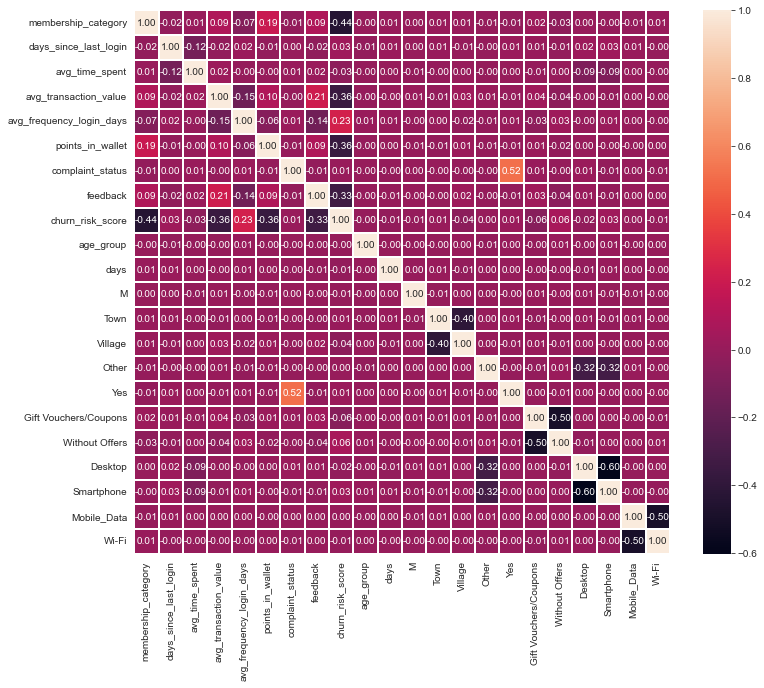

In [51]:
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt='.2f', linewidth=0.05);

In [52]:
y = df['churn_risk_score']
X = df.drop(['churn_risk_score'], axis=1)

In [53]:
from sklearn.preprocessing import PolynomialFeatures

trans = PolynomialFeatures(degree=2)
X = trans.fit_transform(X)

In [54]:
X.shape

(28392, 253)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state=42)

# Modelling

## Gradient Boosting Machines

In [56]:
gbm_model = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8150974407137825

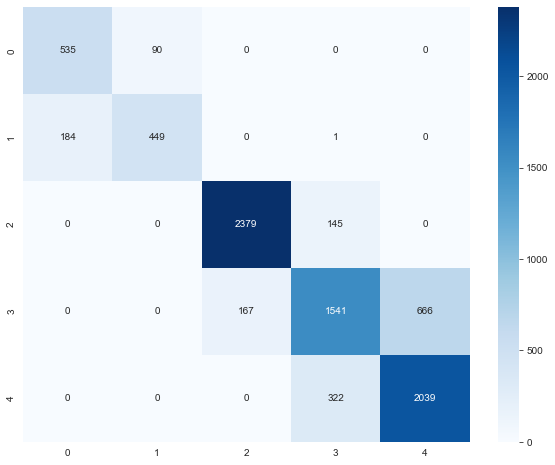

In [57]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')
plt.show();

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.86      0.80       625
           1       0.83      0.71      0.77       634
           2       0.93      0.94      0.94      2524
           3       0.77      0.65      0.70      2374
           4       0.75      0.86      0.80      2361

    accuracy                           0.82      8518
   macro avg       0.81      0.80      0.80      8518
weighted avg       0.82      0.82      0.81      8518



## CatBoost

In [59]:
cat_model = CatBoostClassifier().fit(X_train, y_train, verbose = False)
y_pred = cat_model.predict(X_test)

In [60]:
accuracy_score(y_test, y_pred)

0.8098145104484621

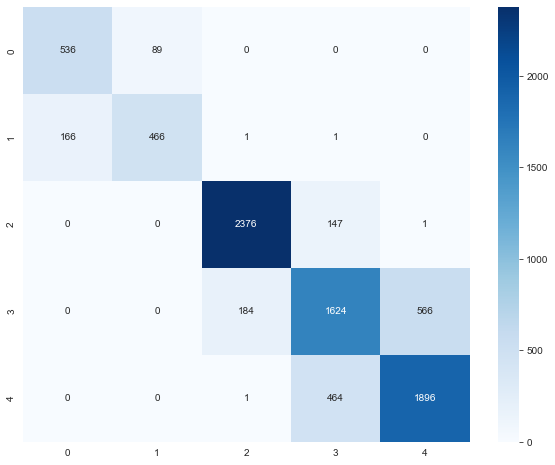

In [61]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')
plt.show();

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       625
           1       0.84      0.74      0.78       634
           2       0.93      0.94      0.93      2524
           3       0.73      0.68      0.70      2374
           4       0.77      0.80      0.79      2361

    accuracy                           0.81      8518
   macro avg       0.81      0.80      0.80      8518
weighted avg       0.81      0.81      0.81      8518



## Light GBM

In [63]:
lgbm_model = LGBMClassifier().fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8168584174688894

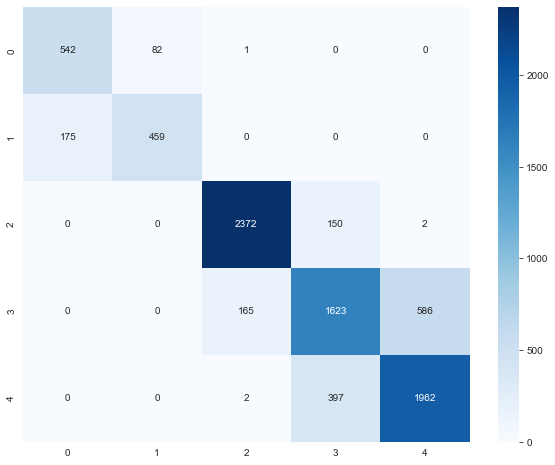

In [64]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')
plt.show();

In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       625
           1       0.85      0.72      0.78       634
           2       0.93      0.94      0.94      2524
           3       0.75      0.68      0.71      2374
           4       0.77      0.83      0.80      2361

    accuracy                           0.82      8518
   macro avg       0.81      0.81      0.81      8518
weighted avg       0.82      0.82      0.82      8518



In [66]:
lgbm_params = {
        'n_estimators': [100, 500, 1000],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.01, 0.05],
        "min_child_samples": [5, 10]}

lgbm = LGBMClassifier()

lgbm_cv_model = GridSearchCV(lgbm, lgbm_params, 
                             cv = 5, 
                             n_jobs = -1, 
                             verbose = 0)



In [67]:
lgbm_cv_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': [3, 4, 5], 'min_child_samples': [5, 10],
                         'n_estimators': [100, 500, 1000]})

In [68]:
lgbm_cv_model.best_params_

{'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_samples': 10,
 'n_estimators': 100}

In [69]:
lgbm = LGBMClassifier(learning_rate = 0.05, 
                       max_depth = 5,
                       n_estimators = 100,
                       min_child_samples = 10)

In [70]:
lgbm_tuned = lgbm.fit(X_train,y_train)

In [71]:
y_pred = lgbm_tuned.predict(X_test)
accuracy_score(y_test, y_pred)

0.8246067151913595

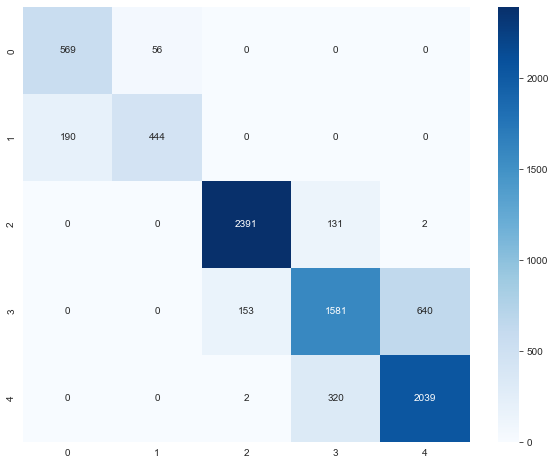

In [72]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g', cmap='Blues')
plt.show()

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.91      0.82       625
           1       0.89      0.70      0.78       634
           2       0.94      0.95      0.94      2524
           3       0.78      0.67      0.72      2374
           4       0.76      0.86      0.81      2361

    accuracy                           0.82      8518
   macro avg       0.82      0.82      0.81      8518
weighted avg       0.83      0.82      0.82      8518

